In [84]:
import pyspark
from pyspark.sql.functions import *
from pyspark.sql import SparkSession
import warnings
warnings.filterwarnings('ignore')
import boto3
import awswrangler

-------------------------------------------
Batch: 1
-------------------------------------------
+----------+---------+-------+
|      date|  borough|zipcode|
+----------+---------+-------+
|01/01/2019|   QUEENS|  11373|
|01/01/2019|     null|   null|
|01/01/2019|   QUEENS|  11413|
|01/01/2019|   QUEENS|  11413|
|01/01/2019|     null|   null|
|01/01/2019|     null|   null|
|01/01/2019|MANHATTAN|  10037|
|01/01/2019| BROOKLYN|  11217|
|01/01/2019|   QUEENS|  11419|
+----------+---------+-------+



In [ ]:
sparker = SparkSession.builder.appName("stream reading"). \
                getOrCreate()

In [ ]:
### Creating sparksession that reads from the stream

read_lines = sparker.readStream.format("socket"). \
            option("host","localhost"). \
            option("port",9999). \
            load()

In [ ]:
read_lines.printSchema()

In [ ]:
counting_sheep = read_lines.select(split("value",' ').alias('words')). \
                    groupBy('words'). \
                    agg(count('words').alias('word_count'))

In [ ]:
counting_sheep.printSchema()

In [ ]:
writing_count = counting_sheep.writeStream \
            .format('console') \
            .outputMode('update') \
            .start()

writing_count.awaitTermination()

In [ ]:
practiceList = [
    [1,"This line is the first of many"],
    [2,"Machine is talking a lot"],
    [3,"Making Machines speak has been the passion for many"]
]
schema_df = ["id int","line string"]
practiceDF = sparker.createDataFrame(data=practiceList,schema=schema_df)

In [ ]:
practiceDF.printSchema()

In [ ]:
count_sample.show()

In [ ]:
sparker.stop()

In [2]:
newSparker = SparkSession \
    .builder \
    .appName("Streaming Process Files") \
    .config("spark.streaming.stopGracefullyOnShutdown", True) \
    .master("local[*]") \
    .getOrCreate()

23/01/26 10:00:02 WARN Utils: Your hostname, codeStation resolves to a loopback address: 127.0.1.1; using 192.168.78.83 instead (on interface wlo1)
23/01/26 10:00:02 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


23/01/26 10:00:04 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [3]:
newSparker.conf.set("spark.sql.streaming.schemaInference", True)
newSparker.conf.set("spark.sql.adaptive.enabled",False)

In [4]:
### Creating sparksession that reads from the stream

read_lines = newSparker.readStream.format("socket"). \
            option("host","localhost"). \
            option("port",9999). \
            load()

23/01/26 10:00:37 WARN TextSocketSourceProvider: The socket source should not be used for production applications! It does not support recovery.


In [5]:
#Now we can count the sheep jumping in the spark stream

count_sheep_1 = read_lines.select(explode(split('value',' ')).alias('words')). \
                        groupBy('words'). \
                        agg(count('words').alias('count_words'))
count_sheep_1.printSchema()

root
 |-- words: string (nullable = false)
 |-- count_words: long (nullable = false)



In [12]:
#To write the output to file watermarking is required

count_sheep_1 = read_lines.select(explode(split('value',' ')).alias('words')). \
                        groupBy('words'). \
                        agg(count('words').alias('count_words'))
count_sheep_1.printSchema()

root
 |-- words: string (nullable = false)
 |-- count_words: long (nullable = false)



In [21]:
writeDf = count_sheep_1.writeStream.format("memory"). \
        queryName('stream_table'). \
        outputMode("update"). \
        start()

23/01/26 07:08:34 WARN ResolveWriteToStream: Temporary checkpoint location created which is deleted normally when the query didn't fail: /tmp/temporary-3ce32e7d-6d36-4ccf-b142-beefd5325ad1. If it's required to delete it under any circumstances, please set spark.sql.streaming.forceDeleteTempCheckpointLocation to true. Important to know deleting temp checkpoint folder is best effort.


In [23]:
# Next lets get the output from the table

newSparker.sql("SELECT * FROM stream_table").show()

+--------+-----------+
|   words|count_words|
+--------+-----------+
|     how|          1|
|      me|          1|
|     see|          1|
|   works|          1|
|    this|          1|
|     Let|          1|
|      by|          1|
|   table|          1|
|      in|          1|
|   works|          2|
|updating|          1|
|  memory|          1|
+--------+-----------+



In [6]:
from datetime import datetime

In [7]:
newtime = datetime.now().strftime('%H:%M')

In [8]:
newtime

'10:01'

In [9]:
# Lets see if for each batch execution can be done
count_sheep_1 = read_lines.select(explode(split('value',' ')).alias('words')). \
                        groupBy('words'). \
                        agg(count('words').alias('count_words')). \
                        withColumn('time_date', lit(datetime.now().strftime('%H:%M')))
count_sheep_1.printSchema()

root
 |-- words: string (nullable = false)
 |-- count_words: long (nullable = false)
 |-- time_date: string (nullable = false)



In [54]:
writeDf = count_sheep_1.writeStream.format("memory"). \
        queryName('time_table'). \
        outputMode("update"). \
        start()

23/01/26 10:20:59 WARN ResolveWriteToStream: Temporary checkpoint location created which is deleted normally when the query didn't fail: /tmp/temporary-624e3a61-d46e-4f48-ac3e-1391c77b47eb. If it's required to delete it under any circumstances, please set spark.sql.streaming.forceDeleteTempCheckpointLocation to true. Important to know deleting temp checkpoint folder is best effort.


IllegalArgumentException: Cannot start query with name time_table as a query with that name is already active in this SparkSession

In [55]:
writeDf = count_sheep_1.writeStream.format("memory"). \
        queryName('wat_mar'). \
        outputMode("update"). \
        start()

23/01/26 10:21:24 WARN ResolveWriteToStream: Temporary checkpoint location created which is deleted normally when the query didn't fail: /tmp/temporary-83a0a7ad-ff8f-4631-b748-d1c4106c7f12. If it's required to delete it under any circumstances, please set spark.sql.streaming.forceDeleteTempCheckpointLocation to true. Important to know deleting temp checkpoint folder is best effort.


23/01/26 10:23:54 WARN TextSocketMicroBatchStream: Stream closed by localhost:9999


In [25]:
newSparker.sql("SELECT * FROM time_table").show()

+-----+-----------+---------+
|words|count_words|time_date|
+-----+-----------+---------+
|     |          1|    10:01|
| some|          1|    10:01|
| data|          1|    10:01|
| lets|          1|    10:01|
| work|          1|    10:01|
| give|          1|    10:01|
| some|          2|    10:01|
| more|          1|    10:01|
| data|          2|    10:01|
|  How|          1|    10:01|
| work|          2|    10:01|
|about|          1|    10:01|
+-----+-----------+---------+



In [48]:
import seaborn as sns

The chart updates after the new data is taken from the table and fed into the pandas dataframe. It is not real time streaming

In [27]:
chartingData = newSparker.sql("SELECT * FROM time_table").to_pandas_on_spark()

In [45]:
chartingData = chartingData[chartingData.words != '']

<BarContainer object of 11 artists>

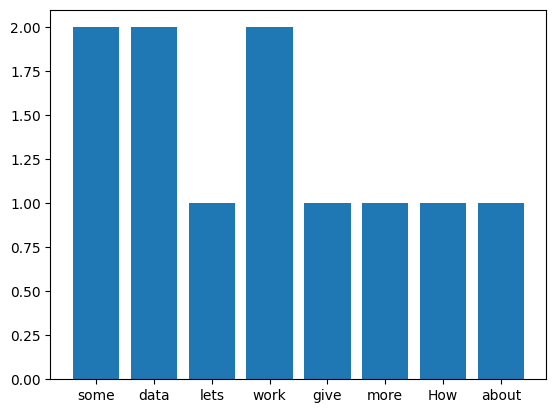

23/01/26 10:19:03 WARN TextSocketMicroBatchStream: Stream closed by localhost:9999


In [53]:
import matplotlib as plt

plt.pyplot.bar(x=chartingData['words'].to_numpy(),
               height=chartingData['count_words'].to_numpy())

In [67]:
#Before trying the file data ingestion, want to check water marking

# Lets see if for each batch execution can be done
count_sheep_wm = read_lines.select(explode(split('value',' ')).alias('words')). \
                        groupBy('words'). \
                        agg(count('words').alias('count_words')). \
                        withColumn('time_date', lit(datetime.now().strftime('%H:%M'))). \
                        withColumn('time_stamp', lit(datetime.now())). \
                        withWatermark('time_stamp','1 seconds')
count_sheep_wm.printSchema()

root
 |-- words: string (nullable = false)
 |-- count_words: long (nullable = false)
 |-- time_date: string (nullable = false)
 |-- time_stamp: timestamp (nullable = false)



In [63]:
count_sheep_wm.writeStream.format("csv"). \
            outputMode("append"). \
            option("checkpointLocation","checkpoint_dir"). \
            option("path","samplespace/"). \
            start()

AnalysisException: Append output mode not supported when there are streaming aggregations on streaming DataFrames/DataSets without watermark;
EventTimeWatermark time_stamp#10968: timestamp, 10 seconds
+- Project [words#10957, count_words#10961L, time_date#10964, 2023-01-26 10:28:19.790838 AS time_stamp#10968]
   +- Project [words#10957, count_words#10961L, 10:28 AS time_date#10964]
      +- Aggregate [words#10957], [words#10957, count(words#10957) AS count_words#10961L]
         +- Project [words#10957]
            +- Generate explode(split(value#0,  , -1)), false, [words#10957]
               +- StreamingRelationV2 org.apache.spark.sql.execution.streaming.sources.TextSocketSourceProvider@5ef536b6, socket, org.apache.spark.sql.execution.streaming.sources.TextSocketTable@e94c46a, [host=localhost, port=9999], [value#0]


In [65]:
def foreach_batch_function(df, epoch_id):
    df.where("count_words > 1")

In [66]:
count_sheep_wm.writeStream. \
            foreach(foreach_batch_function). \
            outputMode('')
            start()

23/01/26 10:39:53 WARN ResolveWriteToStream: Temporary checkpoint location created which is deleted normally when the query didn't fail: /tmp/temporary-851895a2-9edd-4cc2-9846-188b36149a76. If it's required to delete it under any circumstances, please set spark.sql.streaming.forceDeleteTempCheckpointLocation to true. Important to know deleting temp checkpoint folder is best effort.


AnalysisException: Append output mode not supported when there are streaming aggregations on streaming DataFrames/DataSets without watermark;
EventTimeWatermark time_stamp#10968: timestamp, 10 seconds
+- Project [words#10957, count_words#10961L, time_date#10964, 2023-01-26 10:28:19.790838 AS time_stamp#10968]
   +- Project [words#10957, count_words#10961L, 10:28 AS time_date#10964]
      +- Aggregate [words#10957], [words#10957, count(words#10957) AS count_words#10961L]
         +- Project [words#10957]
            +- Generate explode(split(value#0,  , -1)), false, [words#10957]
               +- StreamingRelationV2 org.apache.spark.sql.execution.streaming.sources.TextSocketSourceProvider@5ef536b6, socket, org.apache.spark.sql.execution.streaming.sources.TextSocketTable@e94c46a, [host=localhost, port=9999], [value#0]


In [90]:
fileData= newSparker.readStream.format('csv'). \
    option("cleanSource","archive"). \
    option("sourceArchiveDir","checkpoint_dir"). \
    option("maxFilesPerTrigger",1). \
    load('samplesource',)

In [91]:
selectedData = fileData.selectExpr("_c0 as date","_c2 as borough",
                                   "_c3 as zipcode")

In [92]:
selectedData.writeStream.outputMode("append").format('console') \
        .start()

23/01/26 12:47:34 WARN ResolveWriteToStream: Temporary checkpoint location created which is deleted normally when the query didn't fail: /tmp/temporary-26e94f68-4fbf-4af1-b7e0-f2e5595678b9. If it's required to delete it under any circumstances, please set spark.sql.streaming.forceDeleteTempCheckpointLocation to true. Important to know deleting temp checkpoint folder is best effort.


-------------------------------------------
Batch: 0
-------------------------------------------
+----------+---------+-------+
|      date|  borough|zipcode|
+----------+---------+-------+
|      date|  borough|    zip|
|01/01/2019|     null|   null|
|01/01/2019|     null|   null|
|01/01/2019|     null|   null|
|01/01/2019|     null|   null|
|01/01/2019| BROOKLYN|  11219|
|01/01/2019|     null|   null|
|01/01/2019| BROOKLYN|  11208|
|01/01/2019|   QUEENS|  11355|
|01/01/2019|     null|   null|
|01/01/2019|   QUEENS|  11373|
|01/01/2019|     null|   null|
|01/01/2019|   QUEENS|  11413|
|01/01/2019|   QUEENS|  11413|
|01/01/2019|     null|   null|
|01/01/2019|     null|   null|
|01/01/2019|MANHATTAN|  10037|
|01/01/2019| BROOKLYN|  11217|
|01/01/2019|   QUEENS|  11419|
|01/01/2019|    BRONX|  10463|
+----------+---------+-------+
only showing top 20 rows

23/01/26 12:48:05 WARN FileStreamSource$SourceFileArchiver: Fail to move file:/run/media/solverbot/repoA/gitFolders/moreDE/pyspark_Ex

23/01/26 12:50:42 WARN FileStreamSource$SourceFileArchiver: Fail to move file:/run/media/solverbot/repoA/gitFolders/moreDE/pyspark_Exercises/samplesource/part_003.csv to file:/run/media/solverbot/repoA/gitFolders/moreDE/pyspark_Exercises/checkpoint_dir/run/media/solverbot/repoA/gitFolders/moreDE/pyspark_Exercises/samplesource/part_003.csv / skip moving file.
23/01/26 12:50:42 WARN FileStreamSource$SourceFileArchiver: Fail to move file:/run/media/solverbot/repoA/gitFolders/moreDE/pyspark_Exercises/samplesource/part_003.csv to file:/run/media/solverbot/repoA/gitFolders/moreDE/pyspark_Exercises/checkpoint_dir/run/media/solverbot/repoA/gitFolders/moreDE/pyspark_Exercises/samplesource/part_003.csv / skip moving file.
23/01/26 12:50:42 WARN FileStreamSource$SourceFileArchiver: Fail to move file:/run/media/solverbot/repoA/gitFolders/moreDE/pyspark_Exercises/samplesource/part_003.csv to file:/run/media/solverbot/repoA/gitFolders/moreDE/pyspark_Exercises/checkpoint_dir/run/media/solverbot/repoA